In [1]:
from matplotlib import pyplot as plt
%matplotlib widget

In [2]:

import serial
import numpy as np
import struct
from matplotlib import pyplot as plt

import time
import os
import h5py as h5
import pandas as pd
import arrow
from scipy.ndimage import fourier_shift
from scipy.stats import linregress
from pyopm.stage import sutterMP285


In [3]:
stage=sutterMP285('COM4')
stage.stepMult=25
pos0=stage.getPosition()

Serial<id=0x27977fc2fe0, open=True>(port='COM4', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=30, xonxoff=False, rtscts=False, dsrdtr=False)
StepMult is set to 25 !
sutterMP285: get status info
(128, 0, 2, 4, 7, 0, 99, 0, 99, 0, 20, 0, 136, 19, 1, 124, 112, 23, 16, 39, 0, 0, 0, 0, 144, 1, 144, 1, 200, 0, 11, 3)
step_mul (usteps/um): 25
xspeed" [velocity] (usteps/sec): 200
velocity scale factor (usteps/step): 10
sutterMP285 ready
sutterMP285 : Stage position 
X: -587.04 um 
 Y: 44.2 um
 Z: 1253.08 um


In [4]:

p=os.path.join("D:\\",arrow.now().format('YYYYMMDD_HHmm_')+'opm_calibration')
name='reg'

In [5]:
if not os.path.exists(p):
    os.mkdir(p)


#### Manual Measuring of the Angle

Open GUI and Preview Bead Plane, Choose a bead on the camera surface that is in focus and register position p1

In [7]:
p1=stage.getPosition()
thetas=[]
ps=[]
print(p1)

sutterMP285 : Stage position 
X: -358.6 um 
 Y: -756.28 um
 Z: -6020.96 um
[ -358.6   -756.28 -6020.96]


for a bunch of position throughout the axial FOV bring the bead in focus with help the Z and Y controller of the stage and for every position execute to register it:

In [42]:
p2=stage.getPosition()
ps.append(p2)
thetas.append(np.arctan((p2-p1)[0]/(p2-p1)[2]))
theta=thetas[-1]

sutterMP285 : Stage position 
X: -360 um 
 Y: -784.28 um
 Z: -6083.96 um


In [43]:
ps=np.array(ps)
theta=np.nanmedian(np.arctan((ps[:,0]-ps[0,0])/(ps[:,2]-ps[0,2])))
ps_df=pd.DataFrame(ps)
ps_df2=ps_df-p1
ps_df2.to_csv(os.path.join(p,'angle_measurement.csv'))

C:\Users\jlab\anaconda3\envs\opm\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


27.270758036485084


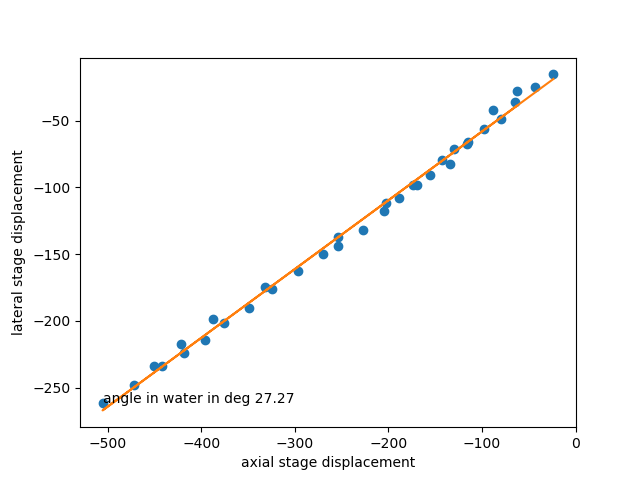

In [44]:
fig,ax=plt.subplots()
res_lin=linregress(ps_df2[2],ps_df2[1])
ax.plot(ps_df2[2],ps_df2[1],'o')
ax.plot(ps_df2[2],ps_df2[2]*res_lin.slope+res_lin.intercept)
theta=np.arctan(res_lin.slope)*180/np.pi
ax.set_xlabel('axial stage displacement')
ax.set_ylabel('lateral stage displacement')
ax.annotate("angle in water in deg {:.2f}".format(np.arctan(res_lin.slope)*180/np.pi),[ps_df2[2].min(),ps_df2[1].min()])
plt.savefig(os.path.join(p,'angle_measurement.pdf'))
print(np.arctan(res_lin.slope)*180/np.pi)

In [45]:
px0=2.5
print('Pixelsize at camera is  {:.2f} micron'.format(px0))
f_tl=45
f_obj1=20
theta=20
fp_theta=35*np.pi/180
pl_theta=np.abs(theta)*np.pi/180
M1=f_tl/f_obj1
px1=px0/M1
print('Pixelsize at straight FP surface is  {:.2f} micron'.format(px1))
px2=px1/np.cos(fp_theta)
print('Pixelsize at oblique FP surface is  {:.2f} micron'.format(px2))
px3=px2*1.33
print('Pixelsize in final unsheared volume is')
print(px3)
#Nex pixelsizes
pxsz_sh = [1, px3*np.cos(pl_theta) ,px1]
print(pxsz_sh)


Pixelsize at camera is  2.50 micron
Pixelsize at straight FP surface is  1.11 micron
Pixelsize at oblique FP surface is  1.36 micron
Pixelsize in final unsheared volume is
1.8040335589474852
[1, 1.695237022993092, 1.1111111111111112]


In [7]:
np.cos(pl_theta)

0.9999814417029145